In [6]:
%load_ext autoreload
%autoreload 2


In [13]:
# load and filter osm network (step 1)
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import time
import networkx as nx
import osmnx as ox
import numpy as np
import pickle
import rasterio as rt
import shapely
import GOSTnets as gn
#import peartree

# Get reference to GOSTNets
import sys
sys.path.insert(1,"/Users/ccsuehara/GH_folders/GOSTnets/GOSTnets")
from fetch_pois import *
#from load_osm import losm
## Can't seem to work https://stackoverflow.com/questions/62858552/why-cant-i-import-geopy-distance-vincenty-on-jupyter-notebook-i-installed-ge


from shapely.geometry import Point, box, Polygon
from shapely.ops import unary_union, linemerge, transform
from shapely.wkt import loads
from shapely import wkt
from shapely.geometry import LineString, MultiLineString, Point

#### Might not use these
import fiona
from osgeo import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob


In [ ]:
##Popoulation sources 
##https://www.worldpop.org/geodata/listing?id=79

In [77]:
def classify_times(x):

    '''
    classsify penalty times according to how flooded a place is. 
    '''

    if x == -99999:
        y = 1
    if math.isnan(x):
        y = 1
    elif x <= 0:
        y = 1
    elif ((x > 0 ) & (x <= .1)):
        y = 2
    elif ((x > .1) & (x <= .25)):
        y = 5
    elif ((x > .25) & (x <= .35)):
        y = 5
    elif ((x > .35) & (x <= .5)):
        y = 9999       
    elif ((x > .35) & (x <= .5)):
        y = 9999
    elif x > .5:
        y = 9999

    return y

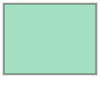

In [3]:
city = gpd.read_file("../data/Kumasi_shp/clipping_boundary.geojson").set_crs(epsg=4326)
bound = city.geometry.iloc[0]
bound.buffer(0)

In [11]:
#gDrive = ox.graph_from_polygon(bound, network_type= 'all', simplify=False, clean_periphery=False)
#gDrive = ox.project_graph(gDrive, to_crs='epsg:4326')

#gn.save(gDrive, '../data/Graphs/Kumasi', '', edges = True, nodes = True)

# If restarting, reload.
gDrive = nx.read_gpickle("../data/Graphs/Kumasi.pickle")

gDrive_node_gdf = gn.node_gdf_from_graph(gDrive)
gDrive_edge_gdf = gn.edge_gdf_from_graph(gDrive)

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


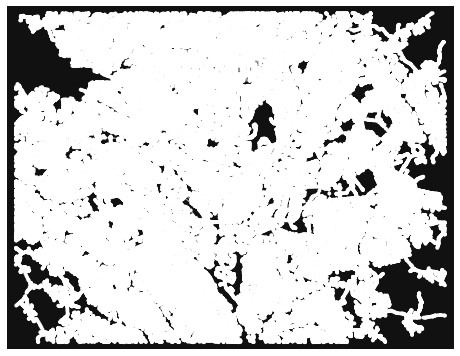

In [12]:
fig, ax = ox.plot_graph(gDrive)

In [28]:
speed_dict = {
                'residential': 40,  # kmph
                'primary': 80, 
                'primary_link':60,
                'trunk': 80,
                'trunk_link':60,
                'secondary': 70, 
                'secondary_link':50,
                'service': 40,
                'tertiary':60,
                'tertiary_link': 40,
                'unclassified':50, 
                'road':50,
                'track':25,
                'path':4.5,
                }

In [29]:
gTime = gn.convert_network_to_time(gDrive, distance_tag = 'length', graph_type='drive', speed_dict = speed_dict)

In [33]:
gTime_node_gdf = gn.node_gdf_from_graph(gTime)
gTime_edge_gdf = gn.edge_gdf_from_graph(gTime)


/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,stnode,endnode,highway,access,lanes,service,oneway,width,length,maxspeed,tunnel,ref,mode,bridge,name,osmid,time,junction,geometry
0,330232536,4089157216,trunk,NaN,NaN,NaN,True,6,24.292,NaN,NaN,N10,drive,NaN,Kumasi - Techiman,406862704,1.093140,NaN,"LINESTRING (-1.62839 6.71340, -1.62830 6.71320)"
1,4089157216,8853235943,trunk,NaN,NaN,NaN,True,6,10.194,NaN,NaN,N10,drive,NaN,Kumasi - Techiman,406862704,0.458730,NaN,"LINESTRING (-1.62830 6.71320, -1.62827 6.71311)"
2,330232597,3724905256,secondary,NaN,NaN,NaN,False,NaN,32.932,NaN,NaN,NaN,drive,NaN,NaN,778491812,1.693646,NaN,"LINESTRING (-1.61956 6.69916, -1.61927 6.69920)"
3,330232597,6009734521,secondary,NaN,NaN,NaN,False,NaN,7.899,NaN,NaN,NaN,drive,NaN,NaN,778491812,0.406234,NaN,"LINESTRING (-1.61956 6.69916, -1.61963 6.69915)"
4,3724905256,3092650910,secondary,NaN,NaN,NaN,True,NaN,58.951,NaN,NaN,NaN,drive,NaN,NaN,448511067,3.031766,NaN,"LINESTRING (-1.61927 6.69920, -1.61873 6.69926)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279246,9498756285,9498756286,service,NaN,NaN,NaN,False,NaN,18.070,NaN,NaN,NaN,drive,NaN,NaN,1030449132,1.626300,NaN,"LINESTRING (-1.64655 6.63567, -1.64666 6.63578)"
279247,9498756286,9498756285,service,NaN,NaN,NaN,False,NaN,18.070,NaN,NaN,NaN,drive,NaN,NaN,1030449132,1.626300,NaN,"LINESTRING (-1.64666 6.63578, -1.64655 6.63567)"
279248,9498756286,9498756287,service,NaN,NaN,NaN,False,NaN,37.431,NaN,NaN,NaN,drive,NaN,NaN,1030449132,3.368790,NaN,"LINESTRING (-1.64666 6.63578, -1.64662 6.63612)"
279249,9498756287,9498756286,service,NaN,NaN,NaN,False,NaN,37.431,NaN,NaN,NaN,drive,NaN,NaN,1030449132,3.368790,NaN,"LINESTRING (-1.64662 6.63612, -1.64666 6.63578)"


In [21]:
## Loading points of destination from "Create Pois.ipynb"
fread = open('../data/Kumasi_places.pickle', "rb")
pod = pickle.load(fread)

In [22]:
#dic_pandana = {}
#for key, val in pod.items():
#    gdf = gn.pandana_snap_c(gDrive, val,  add_dist_to_node_col = True)
#    dic_pandana[key] = gdf

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and wi

In [23]:
with open('../data/pandana_pod_Kumasi.pickle', 'wb') as handle:
    pickle.dump(dic_pandana, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
population = gpd.read_file('../data/Kumasi/Kumasi_pop_unadj_2020.shp').set_crs(epsg=4326)
population['centroid'] = population['geometry'].centroid
population = gpd.GeoDataFrame(population, geometry = population['centroid']).set_crs(epsg=4326)

/var/folders/fw/9znznnm56pn2r_tnfxv4lcfc0000gn/T/ipykernel_69260/864416107.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  population['centroid'] = population['geometry'].centroid


In [44]:
gdf_popu = gn.pandana_snap_c(gDrive, population,  add_dist_to_node_col = True)

In [46]:
gdf_popu.DN

3273460

In [71]:
ev_5yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_5.shp")
ev_10yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_10.shp")
ev_20yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_20.shp")
ev_50yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_50.shp")
ev_100yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_100.shp")
ev_200yr = gpd.read_file("../data/processed/Kumasi/merged/new/ev_200.shp")


ev_5yr.crs = 'init=epsg:4326'
ev_10yr.crs = 'init=epsg:4326'
ev_20yr.crs = 'init=epsg:4326'
ev_50yr.crs = 'init=epsg:4326'
ev_100yr.crs = 'init=epsg:4326'
ev_200yr.crs = 'init=epsg:4326'

for x in [ev_5yr, ev_10yr,ev_20yr,ev_50yr,ev_100yr,ev_200yr]:
    x['DN'] = x['DN']/1000
    x.loc[x['DN'] == -9999, 'DN'] = 0

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [76]:
# edge_5yr = gpd.sjoin(gTime_edge_gdf, ev_5yr, how = "left")
# edge_10yr = gpd.sjoin(gTime_edge_gdf, ev_10yr, how = "left")
# edge_20yr = gpd.sjoin(gTime_edge_gdf, ev_20yr, how = "left")
# edge_50yr = gpd.sjoin(gTime_edge_gdf, ev_50yr, how = "left")
# edge_100yr = gpd.sjoin(gTime_edge_gdf, ev_100yr, how = "left")
# edge_200yr = gpd.sjoin(gTime_edge_gdf, ev_200yr, how = "left")


In [91]:
## Eliminating edges that duplicate because of intersecting more than one flood geometry, and keeping the most flooded.

edge_5yr.sort_values('DN', inplace = True)
edge_10yr.sort_values('DN', inplace = True)
edge_20yr.sort_values('DN', inplace = True)
edge_50yr.sort_values('DN', inplace = True)
edge_100yr.sort_values('DN', inplace = True)
edge_200yr.sort_values('DN', inplace = True)


edge_5yr[~edge_5yr.fake_id.duplicated(keep='last')]
edge_10yr[~edge_10yr.fake_id.duplicated(keep='last')]
edge_20yr[~edge_20yr.fake_id.duplicated(keep='last')]
edge_50yr[~edge_50yr.fake_id.duplicated(keep='last')]
edge_100yr[~edge_100yr.fake_id.duplicated(keep='last')]
edge_200yr[~edge_200yr.fake_id.duplicated(keep='last')]





,stnode,endnode,highway,access,lanes,service,oneway,width,length,maxspeed,...,mode,bridge,name,osmid,time,junction,geometry,fake_id,index_right,DN
0,330232536,4089157216,trunk,NaN,NaN,NaN,True,6,24.292,NaN,...,drive,NaN,Kumasi - Techiman,406862704,1.09314,NaN,"LINESTRING (-1.62839 6.71340, -1.62830 6.71320)",0,8850,0.000
177294,5866159598,5919647639,residential,NaN,NaN,NaN,False,NaN,40.595,NaN,...,drive,NaN,NaN,627063704,3.65355,NaN,"LINESTRING (-1.66558 6.65621, -1.66595 6.65622)",177294,8850,0.000
177295,5866159598,5919647640,residential,NaN,NaN,NaN,False,NaN,28.162,NaN,...,drive,NaN,NaN,627063704,2.53458,NaN,"LINESTRING (-1.66558 6.65621, -1.66554 6.65596)",177295,8850,0.000
177296,5919627213,5866159598,residential,NaN,NaN,NaN,False,NaN,5.916,NaN,...,drive,NaN,NaN,620939019,0.53244,NaN,"LINESTRING (-1.66558 6.65627, -1.66558 6.65621)",177296,8850,0.000
177297,5919627213,5866159600,residential,NaN,NaN,NaN,False,NaN,15.114,NaN,...,drive,NaN,NaN,620939019,1.36026,NaN,"LINESTRING (-1.66558 6.65627, -1.66558 6.65640)",177297,8850,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162062,5850973241,5850973240,residential,NaN,NaN,NaN,False,NaN,19.199,NaN,...,drive,NaN,NaN,619116286,1.72791,NaN,"LINESTRING (-1.66123 6.74005, -1.66128 6.73988)",162062,1624,6.402
162059,5850973239,5850973240,residential,NaN,NaN,NaN,False,NaN,14.333,NaN,...,drive,NaN,NaN,619116286,1.28997,NaN,"LINESTRING (-1.66126 6.73975, -1.66128 6.73988)",162059,1624,6.402
162058,5850973239,5850973238,residential,NaN,NaN,NaN,False,NaN,17.381,NaN,...,drive,NaN,NaN,619116286,1.56429,NaN,"LINESTRING (-1.66126 6.73975, -1.66120 6.73961)",162058,1624,6.402
162057,5850973238,5850973239,residential,NaN,NaN,NaN,False,NaN,17.381,NaN,...,drive,NaN,NaN,619116286,1.56429,NaN,"LINESTRING (-1.66120 6.73961, -1.66126 6.73975)",162057,1624,6.402


In [86]:
for gdf in [edge_5yr, edge_10yr, edge_20yr, edge_50yr, edge_100yr, edge_200yr]:
    gdf['penalty_time'] =  (gdf['DN'].apply(lambda x: classify_times(x)))

In [93]:
help(classify_times)



Help on function classify_times in module __main__:

classify_times(penalty_dic, x)
    classsify penalty times according to how flooded a place is.



In [59]:
edge_before_5yr['penalty_time'] =  (edge_before_5yr['pre5_max'].
                                            apply(lambda x: classify_times(penalty_dic, x)))

stnode      131966
endnode     131970
highway         17
access           1
lanes            2
service          3
oneway           2
width            2
length       60365
maxspeed         2
tunnel           1
ref              6
mode             1
bridge           2
name           251
osmid        19719
time         70916
junction         2
geometry    279251
dtype: int64

In [72]:
ev_5yr.DN.value_counts()

0.089    13
0.053    11
0.062    10
0.058    10
0.061    10
         ..
3.354     1
4.814     1
4.420     1
2.381     1
0.626     1
Name: DN, Length: 584, dtype: int64

In [68]:
gTime_edge_gdf.shape

(279251, 19)